In [1]:
###### Config #####
import sys, os, platform
if os.path.isdir("ds-assets"):
  !cd ds-assets && git pull
else:
  !git clone https://github.com/lutzhamel/ds-assets.git
colab = True if 'google.colab' in os.sys.modules else False
system = platform.system() # "Windows", "Linux", "Darwin"
home = "ds-assets/assets/"
sys.path.append(home)

Already up to date.


In [2]:
import pandas as pd
import dsutils
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Load our data and convert it to a Pandas time series dataframe.

In [3]:
# air passenger data
air = pd.read_csv(home+'AirPassengers.csv')
air.columns = ['date','passengers'] # rename columns for convenience
air.index = pd.DatetimeIndex(air['date']) # create a time index
air.drop(columns=['date'], inplace=True)
air.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Text(0, 0.5, 'Number of Passengers')

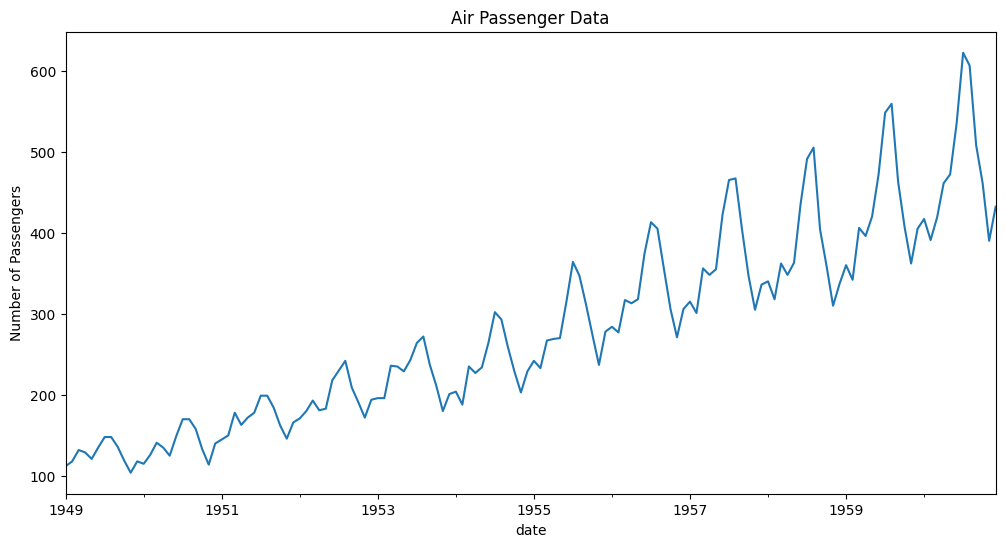

In [4]:
air.plot(figsize=(12,6), title='Air Passenger Data', legend=False)\
      .set_ylabel('Number of Passengers')

In [5]:
# we need this to create our ML training data
first_obs = air.index[0]

# Forecasting

This is about building models of the time series in order to predict values that are not part of the training set.

As a first step we perform seasonal decomposition.

In [6]:
decomp = seasonal_decompose(
        air['passengers'],
        model='multiplicative',
        extrapolate_trend = 6 # have to include, centered moving avg
    )

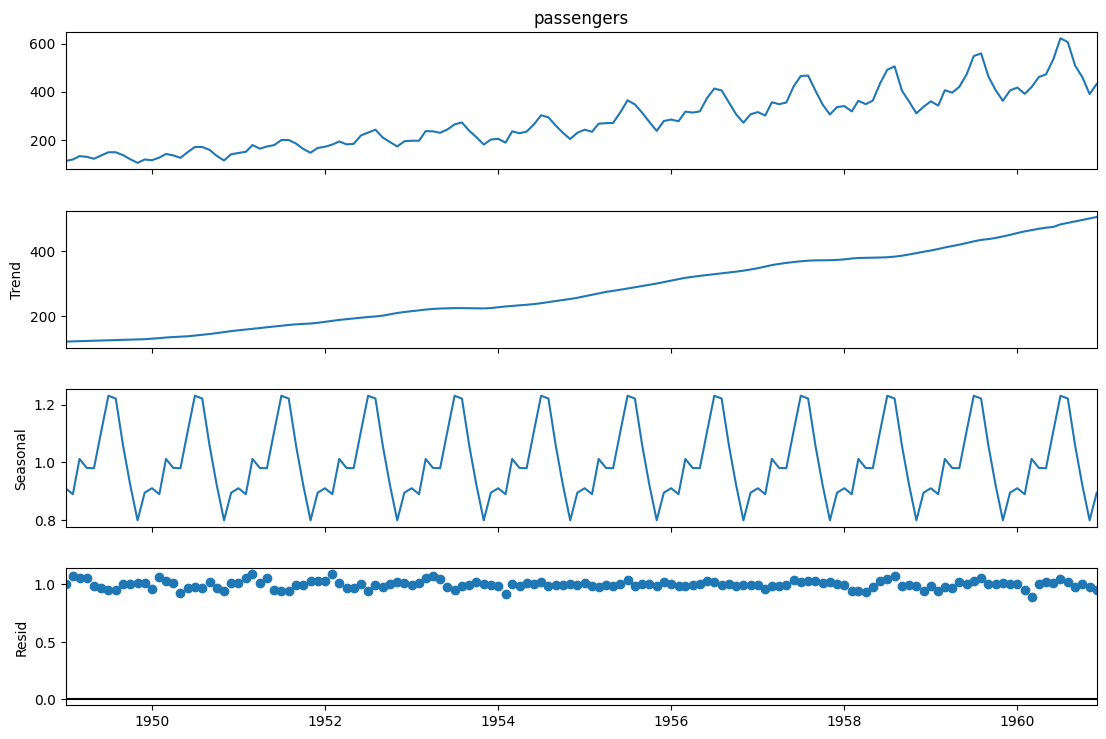

In [7]:
decomp.plot().set_size_inches(12, 8)

## Feature Engineering

We can't do modeling with Pandas' DatetimeIndex objects as the independent variable.  Therefore, we create a new variable called **timedelta** which simply **counts the number of days** from the start of the model data.  That new variable will become our independent variable as a proxy for the DatetimeIndex obects.  This is often called **feature engineering**.

In [8]:
timedelta = list((air.index - first_obs).days) # timedelta in days
timedelta

[0,
 31,
 59,
 90,
 120,
 151,
 181,
 212,
 243,
 273,
 304,
 334,
 365,
 396,
 424,
 455,
 485,
 516,
 546,
 577,
 608,
 638,
 669,
 699,
 730,
 761,
 789,
 820,
 850,
 881,
 911,
 942,
 973,
 1003,
 1034,
 1064,
 1095,
 1126,
 1155,
 1186,
 1216,
 1247,
 1277,
 1308,
 1339,
 1369,
 1400,
 1430,
 1461,
 1492,
 1520,
 1551,
 1581,
 1612,
 1642,
 1673,
 1704,
 1734,
 1765,
 1795,
 1826,
 1857,
 1885,
 1916,
 1946,
 1977,
 2007,
 2038,
 2069,
 2099,
 2130,
 2160,
 2191,
 2222,
 2250,
 2281,
 2311,
 2342,
 2372,
 2403,
 2434,
 2464,
 2495,
 2525,
 2556,
 2587,
 2616,
 2647,
 2677,
 2708,
 2738,
 2769,
 2800,
 2830,
 2861,
 2891,
 2922,
 2953,
 2981,
 3012,
 3042,
 3073,
 3103,
 3134,
 3165,
 3195,
 3226,
 3256,
 3287,
 3318,
 3346,
 3377,
 3407,
 3438,
 3468,
 3499,
 3530,
 3560,
 3591,
 3621,
 3652,
 3683,
 3711,
 3742,
 3772,
 3803,
 3833,
 3864,
 3895,
 3925,
 3956,
 3986,
 4017,
 4048,
 4077,
 4108,
 4138,
 4169,
 4199,
 4230,
 4261,
 4291,
 4322,
 4352]

Create our feature matrix.  In addition to the timedelta feature **we also include a variable called 'month'** that tells us which month of the year we are currently looking at.  This will become important when we do **seasonal modeling**.

Here is our feature matrix.

In [29]:
X = pd.DataFrame({'timedelta': timedelta,  # trend modeling
                  'month': air.index.month, # seasonality modeling
                  },
                  index=air.index)

X.head(n=24) # show first 24 months

,timedelta,month
date,,
1949-01-01,0,1
1949-02-01,31,2
1949-03-01,59,3
1949-04-01,90,4
1949-05-01,120,5
1949-06-01,151,6
1949-07-01,181,7
1949-08-01,212,8
1949-09-01,243,9


## Trend Modeling

We start with trend forecasting.  We first extract the trend information from the time series by applying the rolling window methodology.

In [10]:
air_trend = decomp.trend

Text(0, 0.5, 'Number of Passengers')

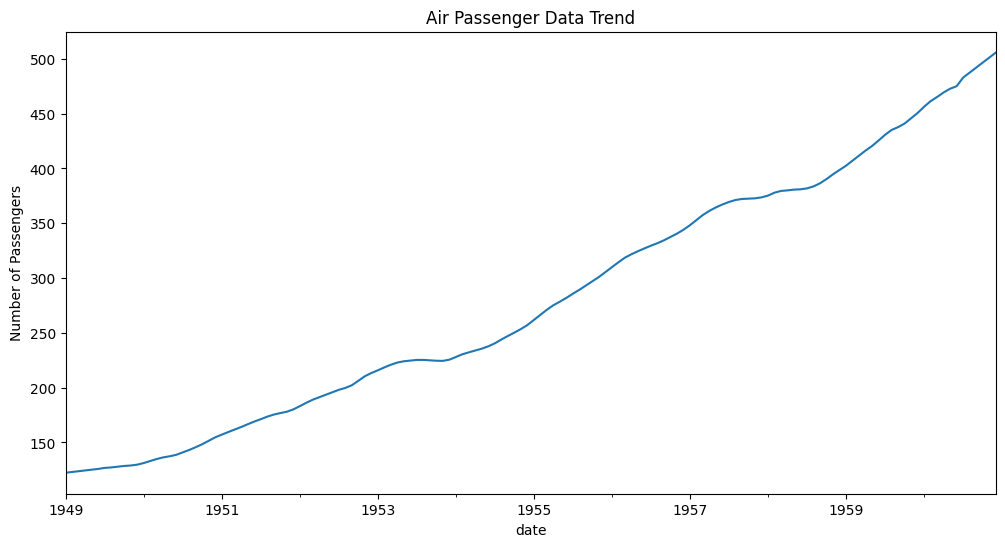

In [11]:
air_trend.plot(figsize=(12,6), title='Air Passenger Data Trend', legend=False)\
      .set_ylabel('Number of Passengers') 

### Linear Regression

In [12]:
X_trend = X[['timedelta']]
y_trend = air_trend

In [13]:

# Fit a linear regression model
linear_model = LinearRegression().fit(X_trend, y_trend)

Text(0, 0.5, 'Number of Passengers')

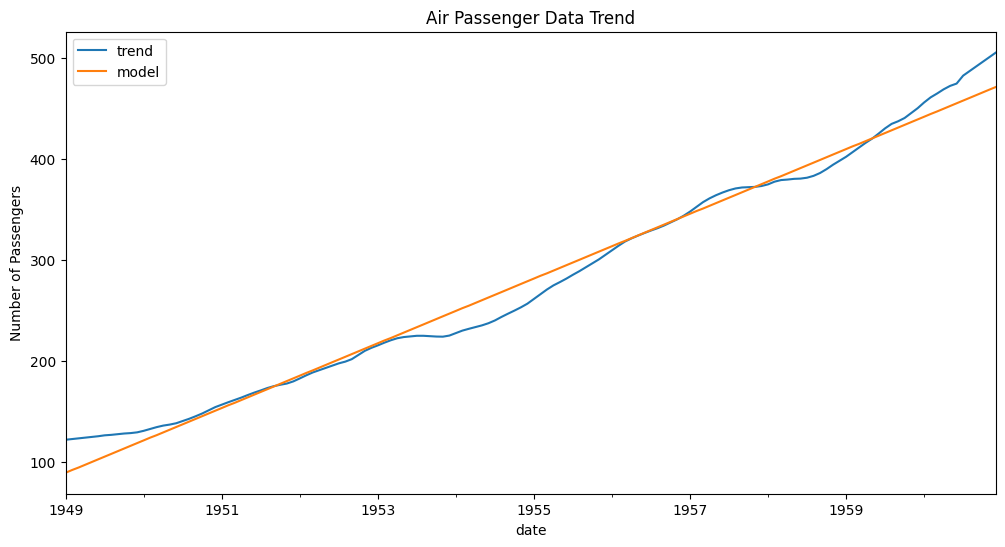

In [14]:
# visualize the fit
pd.DataFrame({'trend':air_trend,
              'model':linear_model.predict(X_trend)})\
         .plot(figsize=(12,6), title='Air Passenger Data Trend', legend=True)\
         .set_ylabel('Number of Passengers') 


In [15]:
# compute the R^2 score
dsutils.rs_score(linear_model, X_trend, y_trend, as_string=True)

'R^2 Score: 0.99 (0.98, 0.99)'

## Seasonal Modeling

Next we build a model on the seasonal data.  We will use a **gradient boosting regression** model.

In [16]:
air_seasonal = decomp.seasonal

Text(0, 0.5, 'Seasonal Component')

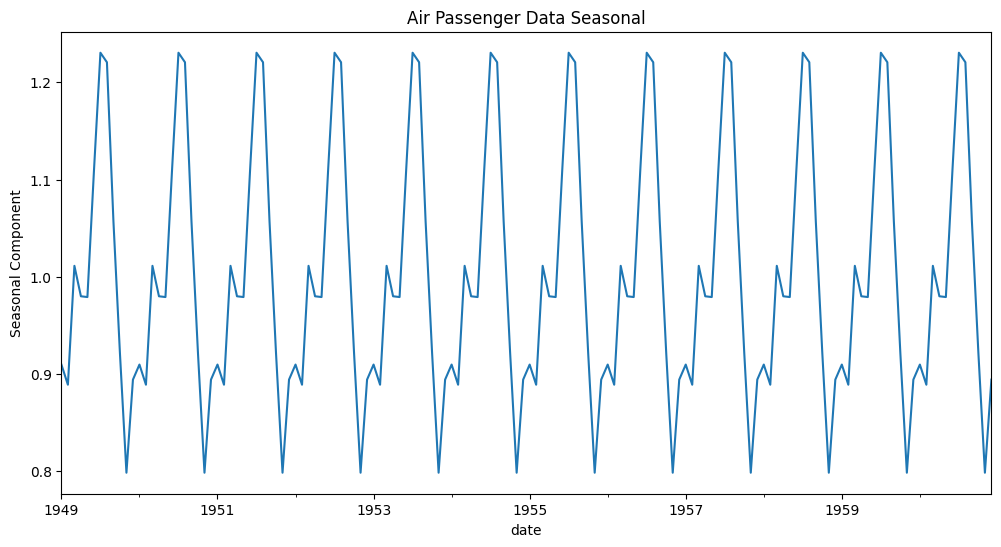

In [17]:

air_seasonal.plot(figsize=(12,6), title='Air Passenger Data Seasonal', legend=False)\
      .set_ylabel('Seasonal Component')

We can see that the seasonal period is 12 months.  **We will construct a seasonal model for 1 period**.  Since the pattern repeats itself every 12 months we only need to model the first 1st period, i.e., the first twelve months,

In [18]:
X_season = X[:12][['month']]
y_season = air_seasonal[:12]


### Gradient Boosting Regression

In [ ]:

# fit a gradient boosting (default) model
gbr_model = GradientBoostingRegressor().fit(X_season,y_season)


Text(0, 0.5, 'Number of Passengers')

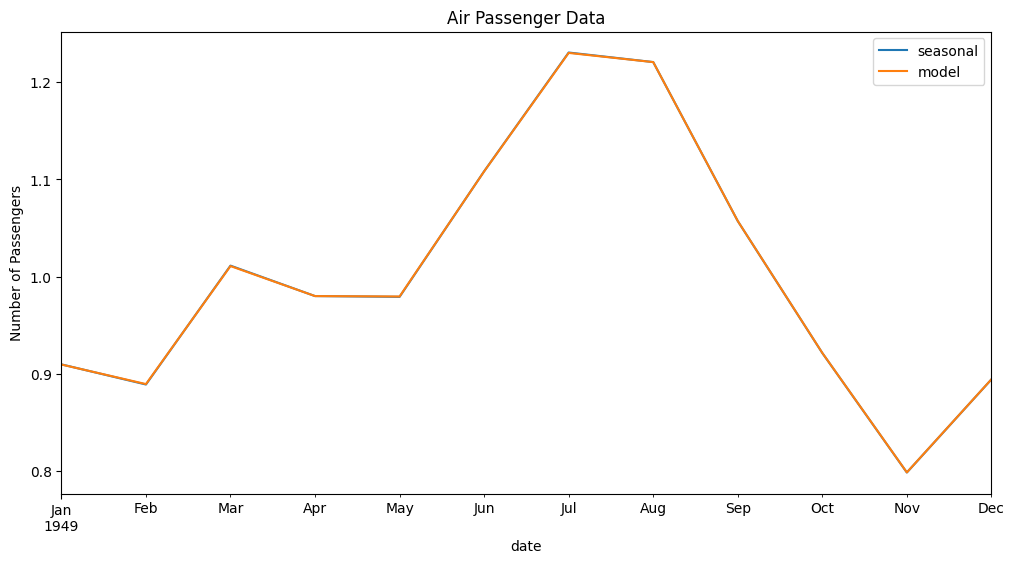

In [20]:
pd.DataFrame({'seasonal':y_season,
              'model':gbr_model.predict(X_season)})\
         .plot(figsize=(12,6), title='Air Passenger Data', legend=True)\
         .set_ylabel('Number of Passengers')

In [32]:
dsutils.rs_score(gbr_model, X_season, y_season, as_string=True)

'R^2 Score: 1.00 (1.00, 1.00)'

## Forecasting Model

Our forecasting model will combine trend and the seasonal models.

In [22]:
def predict_air_passengers(X):
    """
    Predict the number of air passengers given a timedelta and month.
    """
    # Predict the trend
    trend = linear_model.predict(X[['timedelta']])
    
    # Predict the seasonal component
    seasonal = gbr_model.predict(X[['month']])
    
    # Return the predicted number of passengers - multiplicative model
    return trend * seasonal


Test our model on our training data.

In [23]:
y_pred = predict_air_passengers(X)

Text(0, 0.5, 'Number of Passengers')

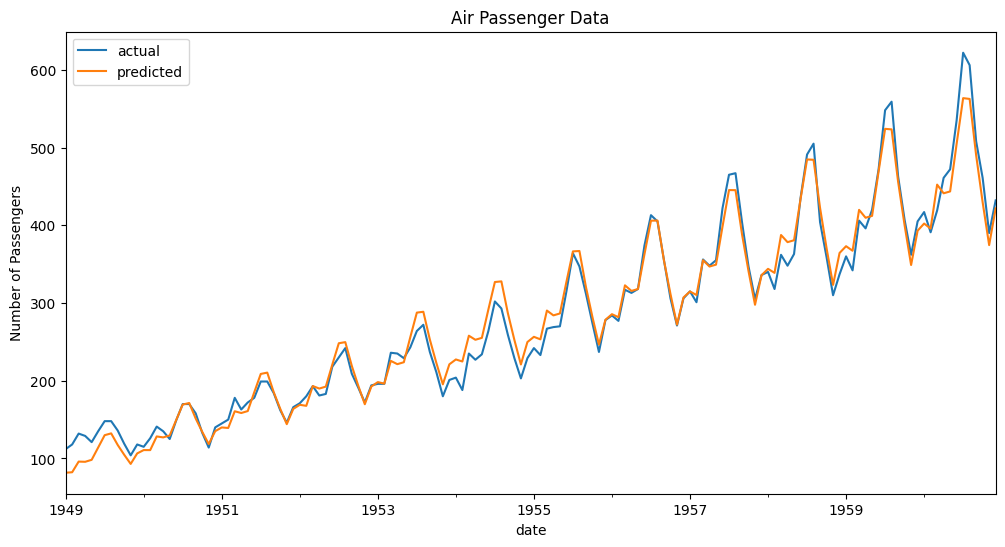

In [24]:
pd.DataFrame({'actual': air['passengers'],
              'predicted': y_pred})\
          .plot(figsize=(12,6), title='Air Passenger Data', legend=True)\
          .set_ylabel('Number of Passengers')   

Forecast a date range we haven't seen yet.

In [25]:
start = '1961'
end = '1973'

In [26]:
new_index = pd.DatetimeIndex(pd.date_range(start, end, freq='MS'))

X_new = pd.DataFrame({'timedelta': list((new_index - first_obs).days),
                      'month': new_index.month},
                      index=new_index)
X_new


,timedelta,month
1961-01-01,4383,1
1961-02-01,4414,2
1961-03-01,4442,3
1961-04-01,4473,4
1961-05-01,4503,5
...,...,...
1972-09-01,8644,9
1972-10-01,8674,10
1972-11-01,8705,11
1972-12-01,8735,12


In [27]:
y_pred = predict_air_passengers(X_new)

Text(0, 0.5, 'Number of Passengers')

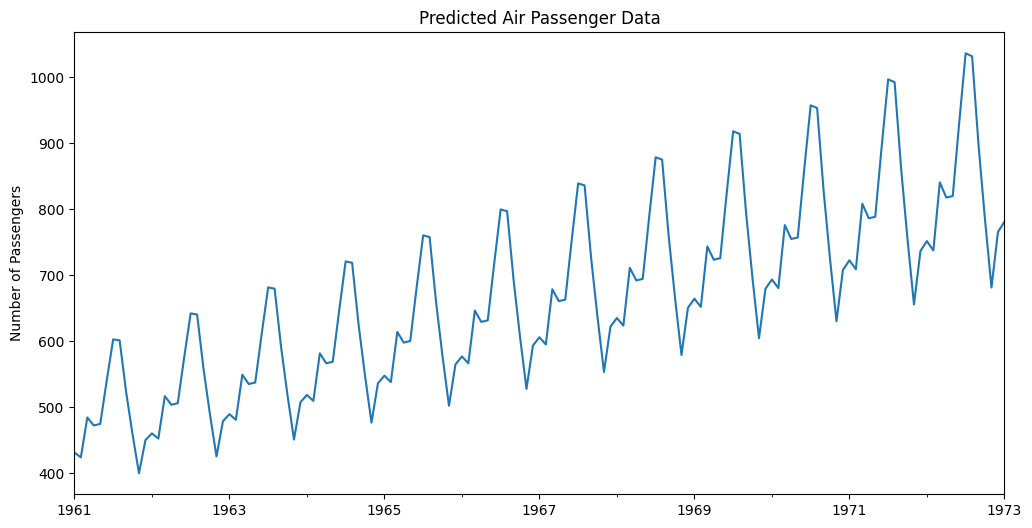

In [28]:
pd.DataFrame({'predicted': y_pred}, index=new_index)\
      .plot(figsize=(12,6), title='Predicted Air Passenger Data', legend=False)\
      .set_ylabel('Number of Passengers')